# Solve frozen lake with simple Actor-Critic

Solve the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) environment using simple actor-critic method.

This approach employs a state-value function, $V_\theta$, as the critic, which can be updated using bootstrapping:

$$
V(s;\theta) \leftarrow V(s;\theta) + \alpha \delta \ ,
$$

where $\delta = r + \gamma V(s';\theta) - V(s;\theta)$ is the TD error.

Since we use a neural network to represent $V$, we cannot do this assignment directly, but instead perform a gradient update using squared loss:

$$
L(\theta) = \delta^2 \ ,
$$

with transitions $(s,a,r,s')$ sampled from the environment using the actor for action selection.

The actor is a parameterized policy, $\pi_\phi$, which is also updated using the TD errors from the critic.

$$
\nabla_\phi \mathbb{E}[R|\phi] \approx \nabla_\phi \log p_\phi(a|s) \, \delta \ ,
$$



Algorithm:

1. Do a forward pass of the current state, $s$, with the policy to get action probabilities.
2. Sample an action, $a$, and take a step in the environment to observe a reward and next state, $r,s'$.
3. Do a forward pass of the next state, $s'$, with the state-value function to get a value estimate, $V(s')$.
4. Compute the TD error, $\delta$, and update the state-value function parameters with backpropagation.
6. Use the TD error to update the policy parameters with backpropagation.
7. Set $s \leftarrow s'$ and repeat.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.nn import relu, softmax
from tensorflow.python.ops.init_ops import RandomUniform
import gym

In [2]:
env = gym.make('FrozenLake-v0')

[2018-01-05 20:56:25,754] Making new env: FrozenLake-v0


In [3]:
# show init state
s = env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [4]:
class Actor(object):
    """Policy network"""
    
    def __init__(self, n_inputs, n_outputs, learning_rate):
        with tf.variable_scope('actor'):
            # placeholders
            self.states = tf.placeholder(tf.float32, [None, n_inputs], name='states')
            self.actions = tf.placeholder(tf.int32, [None, 2], name='actions')
            self.deltas = tf.placeholder(tf.float32, [None], name='deltas')
            # network
            self.out = tf.layers.dense(inputs=self.states, units=n_outputs, activation=softmax, name='out')
            # training
            action_probabilities = tf.gather_nd(self.out, self.actions)
            self.loss = -tf.reduce_mean(tf.multiply(tf.log(action_probabilities), self.deltas))
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.update = optimizer.minimize(self.loss)

In [5]:
class Critic(object):
    """State-value function network"""
    
    def __init__(self, n_inputs, learning_rate):
        with tf.variable_scope('critic'):
            # placeholders
            self.states = tf.placeholder(tf.float32, [None, n_inputs], name='states')
            self.targets = tf.placeholder(tf.float32, [None], name='targets')
            # network
            init = RandomUniform(0, 0.01) # the network is sensitive to weight initialization
            self.out = tf.layers.dense(inputs=self.states, units=1, activation=None, use_bias=False, kernel_initializer=init, name='out')
            # training
            self.delta = self.targets - self.out # TD error
            self.loss = tf.reduce_sum(tf.square(self.delta))
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            self.update = self.optimizer.minimize(self.loss)

In [6]:
def one_hot(i, l):
    """One-hot encoder for the states"""
    a = np.zeros((len(i), l))
    a[range(len(i)), i] = 1
    return a

In [7]:
# train Actor-Critic

num_episodes = 2000
episode_limit = 100
learning_rate_actor = 0.01
learning_rate_critic = 0.1
gamma = 0.99 # discount rate

print_freq = 100

n_inputs = env.observation_space.n
n_outputs = env.action_space.n

tf.reset_default_graph()
actor = Actor(n_inputs, n_outputs, learning_rate_actor)
critic = Critic(n_inputs, learning_rate_critic)

try:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        rewards, lengths, losses_actor, losses_critic = [], [], [], []
        print('start training')
        for i in range(num_episodes):
            s = env.reset()
            reward, loss_actor, loss_critic = 0, 0, 0
            for j in range(episode_limit):
                a_prob = sess.run(fetches=actor.out, feed_dict={actor.states: one_hot([s], n_inputs)})
                a = (np.cumsum(np.asarray(a_prob)) > np.random.rand()).argmax() # sample action
                s1, r, done, _ = env.step(a)
                v1 = sess.run(fetches=critic.out, feed_dict={critic.states: one_hot([s1], n_inputs)})
                target = r + gamma * v1[0] * (not done)
                delta, lc, _ = sess.run(fetches=[critic.delta, critic.loss, critic.update], feed_dict={critic.states: one_hot([s], n_inputs), critic.targets: target})
                la, _ = sess.run(fetches=[actor.loss, actor.update], feed_dict={actor.states: one_hot([s], n_inputs), actor.actions: [[0, a]], actor.deltas: delta[0]}) 
                s = s1
                # bookkeeping
                reward += r
                loss_actor += la
                loss_critic += lc
                if done: break
            # bookkeeping
            rewards.append(reward)
            lengths.append(j+1)
            losses_actor.append(loss_actor)
            losses_critic.append(loss_critic)
            if (i+1) % print_freq == 0: print('%5d avg. training reward: %5.2f' % (i+1, np.mean(rewards[-print_freq:])))
        print('done')
except KeyboardInterrupt:
    pass 

start training
  100 avg. training reward:  0.03
  200 avg. training reward:  0.01
  300 avg. training reward:  0.11
  400 avg. training reward:  0.32
  500 avg. training reward:  0.44
  600 avg. training reward:  0.59
  700 avg. training reward:  0.62
  800 avg. training reward:  0.63
  900 avg. training reward:  0.66
 1000 avg. training reward:  0.71
 1100 avg. training reward:  0.61
 1200 avg. training reward:  0.71
 1300 avg. training reward:  0.68
 1400 avg. training reward:  0.63
 1500 avg. training reward:  0.74
 1600 avg. training reward:  0.71
 1700 avg. training reward:  0.69
 1800 avg. training reward:  0.72
 1900 avg. training reward:  0.77
 2000 avg. training reward:  0.72
done


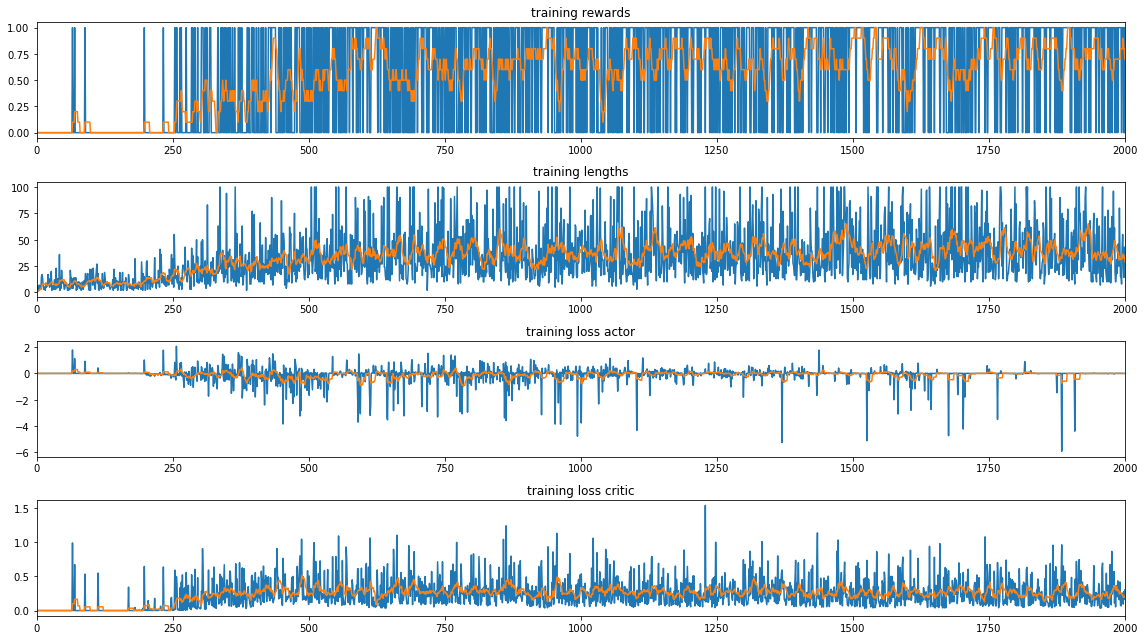

In [8]:
# plot results

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16, 9))
plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, len(rewards)+1), rewards)
plt.plot(range(1, len(rewards)+1), moving_average(rewards))
plt.xlim([0, len(rewards)])
plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, len(lengths)+1), lengths)
plt.plot(range(1, len(lengths)+1), moving_average(lengths))
plt.xlim([0, len(lengths)])
plt.subplot(413)
plt.title('training loss actor')
plt.plot(range(1, len(losses_actor)+1), losses_actor)
plt.plot(range(1, len(losses_actor)+1), moving_average(losses_actor))
plt.xlim([0, len(losses_actor)])
plt.subplot(414)
plt.title('training loss critic')
plt.plot(range(1, len(losses_critic)+1), losses_critic)
plt.plot(range(1, len(losses_critic)+1), moving_average(losses_critic))
plt.xlim([0, len(losses_critic)])
plt.tight_layout(); plt.show()